This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

# Title 
#### Team number
- Xavier Yu, Vilasini Nathan, Justin Lee

In [1]:
from __future__ import annotations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Core
import time
from typing import List, Dict, Optional, Tuple, Iterable

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as w
from IPython.display import display, clear_output, HTML, FileLink

# Web scraping
import requests
from bs4 import BeautifulSoup

# Statistics & Math
import scipy.stats as stats
import pylab as py

# Machine Learning
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, cross_val_score
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, r2_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance


C:\Users\vunathan36\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException

## Introdunction

- One or two paragraphs about the background of the project. eg: the backgound of PalWorld and why your analysis can be interesting
- State your research questions. Limit the number of research questions to be one or two. 

## Data 

### Data Source

- List the website you have scraped the data from.
- List which information you have scraped
- Describe what kind of cleaning you have done to the data

### Webscraping and cleaning functions overview

List all the functions you have written for webscraping and data cleaning. For each one, write one sentence to describe it. 
- `extract_soup()`
    - build url and return soup object

### Data overview

- Show a couple of rows of the cleaned data you are going to use for the analysis
- Which is your target value (if exists)
- Give a general summary about the other features
- Discuss if there is any potential problems about the data (eg: missing values, any features that you did not collect but may be important, any other concerns)

## Webscraping and cleaning

In [2]:
def get_html(url):
    """
    Retrieve HTML content from a given URL

    Args:
        url (str): The webpage URL to fetch HTML from

    Returns:
        str: HTML content as a string.
    """
    response = requests.get(url)
    return response.text


def extract_pal_links(html):
    """
    Extracts and returns a list of links to pals from the HTML soup object.
    
    Args:
        html (string): html text of a webpage
        
    Returns:
        pal_links (list): A list of full URLs to individual pal pages.
    """
    # parse HTML content to create soup
    soup = BeautifulSoup(html)
    
    pal_links = []  # Create an empty list to store full URLs

    # Find all <div> elements with class pal
    for pal_div in soup.find_all('div', class_='pal'):
        
        # Inside each <div class='pal'>, find the first <a> tag
        a_tag = pal_div.find('a')
        
        # Check if the <a> tag exists and has an 'href' attribute
        if a_tag and a_tag.has_attr('href'):
            # Build the full link by appending the relative path to the base URL
            full_link = 'https://palworld.gg' + a_tag['href']
            pal_links.append(full_link)

    return pal_links


def fetch_pal_data(pal_links):
    """
    Given a list of Palworld page links, fetch each page and extract the pal's name and stats.

    Args:
        pal_links (list): A list of full URLs to individual pal pages.

    Returns:
        pal_data (dictionary): dictionary containing a pal's name, link, and stats.
    """    
    name, href, stats = [], [], []

    for link in pal_links:
        # Request the HTML content of each pal's page
        response = requests.get(link)
        if response.status_code != 200:
            continue

        # Parse the HTML using BeautifulSoup
        pal_soup = BeautifulSoup(response.text, 'html.parser')

        # Get the pal's name from the <h1> tag
        name_tag = pal_soup.find('h1')
        pal_name = name_tag.text.strip() if name_tag else 'Unknown'

        # Dictionary to store stats like HP, Attack, etc.
        stats_dict = {}

        # Look for the section containing stats
        stats_div = pal_soup.find('div', class_='stats')
        if stats_div:
            items_div = stats_div.find('div', class_='items')
            if items_div:
                # Loop through all stat items
                for item in items_div.find_all('div', class_='item'):
                    stat_name_tag = item.find('div', class_='name')
                    stat_value_tag = item.find('div', class_='value')
                    if stat_name_tag and stat_value_tag:
                        stat_name = stat_name_tag.text.strip()
                        stat_value = stat_value_tag.text.strip()
                        stats_dict[stat_name] = stat_value

        # Save the collected data into corresponding lists
        name.append(pal_name)
        href.append(link)
        stats.append(stats_dict)
        
    pal_data = {'Name': name, 'Link': href, 'Stats': stats}


    return pal_data




def add_rarity_info(pal_data):
    """
    Adds rarity_level and rarity_name to each pal dictionary
    
    Args:
        pal_data (dictionary): contains pal info with at least a 'Link' key.
        
    Returns:
        pal_data (dictionary): 'Rarity Level' and 'Rarity Name' fields added
    """
    # empty lists to store rarity level and rarity name
    rar_level, rar_name = [], []
    
    for link in pal_data['Link']:
        html = get_html(link)  # FIXED: now using each Pal's page
        soup = BeautifulSoup(html, 'html.parser')

        # Find the rarity div
        rarity_div = soup.find('div', class_='rarity')
        rarity_level, rarity_name = None, None
        if rarity_div:
            lv_tag = rarity_div.find('div', class_='lv')
            name_tag = rarity_div.find('div', class_='name')
            if lv_tag and name_tag:
                rarity_level = lv_tag.text.strip()
                rarity_name = name_tag.text.strip()

        rar_level.append(rarity_level)
        rar_name.append(rarity_name)
        
    pal_data['Rarity Level'] = rar_level
    pal_data['Rarity Name'] = rar_name

    return pal_data



def add_element_work(pal_data):
    """
    Adds element and work suitability to pal_data
    
    Args:
        pal_data (dictionary): Dictionary, with at least a 'Link' key.
        
    Returns:
        pal_data (dictionary): 'Element', 'Work Suitability' added
    
    """
    # empty lists to store element and work suitability
    element, work = [], []
    
    # iterate through all links
    for link in pal_data['Link']:
        
        # get HTML
        html = get_html(link)
        # Parse the HTML content
        soup = BeautifulSoup(html)
        
        # to store all elements of each pal
        pal_element = []
        
        # get contents of first div with class elements
        elements_div = soup.find('div', class_='elements')

        # get text from each element and append to pal_element
        for el in elements_div.find_all('div', class_='name'):
                    element_text = el.text.strip()
                    pal_element.append(element_text)
        
        # empty dict to store work suitability and level
        work_level = {}

        # get contents of first div with class works
        works_div = soup.find('div', class_='works')

        # iterates through contents of work_div with div and class item
        for item in works_div.find_all('div', class_='item'):
            
            # only extracts displayed items
            if 'display:none' not in item.get('style', ''):
                if 'Lv' in item.text:
                    work_suit, level = item.text.split('Lv')
                    work_level[work_suit] = int(level)
                else:
                    work_suit = item.text.strip()
                    work_level[work_suit] = ''
        
        # appends pal_element and work_level to the larger element and work lists
        element.append(pal_element)
        work.append(work_level)
    
    # adds to dictionary
    pal_data['Element'] = element
    pal_data['Work Suitability'] = work
    
    return pal_data




In [3]:
url = 'https://palworld.gg/pals'
html = get_html(url)
pal_links = extract_pal_links(html)

pal_data = fetch_pal_data(pal_links)

In [4]:
pal_data = add_rarity_info(pal_data)

In [5]:
pal_data = add_element_work(pal_data)

In [6]:
pal_info_df = pd.DataFrame(pal_data)


In [ ]:
"""
Palworld Weapons Scraper with Selenium
=====================================

Utilities to scrape weapon data from https://palworld.gg/items by
interacting with the site's filter controls via Selenium, with an
HTML-parsing fallback using BeautifulSoup.

The primary entry point is `scrape_palworld_weapons()` which attempts a
Selenium-driven scrape and returns a tidy pandas DataFrame with columns:
['Name', 'Price', 'Physical Attack', 'Durability'].
"""

from __future__ import annotations

import time
from typing import Optional

import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait, Select  # noqa: F401  (Select kept as alternative)

BASE_URL = "https://palworld.gg/items"


def setup_driver(headless: bool = False) -> webdriver.Chrome:
    """
    Configure and instantiate a Chrome WebDriver.

    Parameters
    ----------
    headless : bool, default False
        Whether to run Chrome in headless mode.

    Returns
    -------
    selenium.webdriver.Chrome
        A configured Chrome WebDriver instance.

    Notes
    -----
    - Requires a compatible ChromeDriver on PATH.
    - Adds sensible defaults for containerized/CI environments
      (e.g., '--no-sandbox', '--disable-dev-shm-usage').
    """
    from selenium.webdriver.chrome.options import Options

    chrome_options = Options()
    if headless:
        # For newer Chrome versions, consider: "--headless=new"
        chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--window-size=1920,1080")

    driver = webdriver.Chrome(options=chrome_options)
    return driver


def scrape_palworld_weapons_selenium(headless: bool = False) -> pd.DataFrame:
    """
    Scrape weapon data from Palworld using Selenium to apply the "Weapon" filter.

    Parameters
    ----------
    headless : bool, default False
        Whether to run the browser in headless mode.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with columns:
        - 'Name' : str
        - 'Price' : int or str (non-numeric preserved if present)
        - 'Physical Attack' : int or str
        - 'Durability' : int or str

    Raises
    ------
    selenium.common.exceptions.TimeoutException
        If critical elements fail to load within the wait time.
    Exception
        Any unexpected runtime error during scraping.

    Notes
    -----
    - Uses JavaScript to set the filter value and dispatch a change event.
    - Performs a simple verification step by sampling the first few results.
    - If parsing yields no rows, an empty DataFrame is returned.
    """
    driver: Optional[webdriver.Chrome] = None
    try:
        print("Setting up browser driver...")
        driver = setup_driver(headless)

        print(f"Navigating to Palworld items page: {BASE_URL}")
        driver.get(BASE_URL)

        wait = WebDriverWait(driver, 15)

        print("Waiting for initial page load...")
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, "item")))
        time.sleep(2)

        print("Waiting for filter dropdown to load...")
        dropdown = wait.until(EC.element_to_be_clickable((By.ID, "item_type")))

        initial_items = len(driver.find_elements(By.CLASS_NAME, "item"))
        print(f"Initial items on page: {initial_items}")

        print("Selecting 'Weapon' from filter...")
        # JS approach tends to be more reliable against custom components
        driver.execute_script(
            """
            const dropdown = document.getElementById('item_type');
            if (dropdown) {
                dropdown.value = 'EPalItemTypeA::Weapon';
                dropdown.dispatchEvent(new Event('change', { bubbles: true }));
            }
            """
        )

        # Alternative if needed:
        # select = Select(dropdown)
        # select.select_by_value("EPalItemTypeA::Weapon")

        print("Waiting for page to update with ALL weapons...")
        time.sleep(3)

        # Best-effort check: wait until item count changes (if it does)
        try:
            previous_count = initial_items

            def items_count_changed(driver_):
                current = len(driver_.find_elements(By.CLASS_NAME, "item"))
                return current != previous_count and current > 0

            WebDriverWait(driver, 5).until(items_count_changed)
        except TimeoutException:
            # It's okay if the count didn't change; continue to parse
            pass

        # Trigger any lazy-loading by scrolling
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        weapon_items = driver.find_elements(By.CLASS_NAME, "item")
        print(f"Found {len(weapon_items)} items after filtering for weapons")

        # Quick verification: confirm at least one item displays "Weapon"
        weapon_count = 0
        for item in weapon_items[:5]:
            try:
                type_div = item.find_element(By.CLASS_NAME, "type")
                if "Weapon" in type_div.text:
                    weapon_count += 1
            except Exception:
                pass

        if weapon_count > 0:
            print("Confirmed: Found weapons in the filtered results")
        else:
            print("Warning: Sample check did not confirm 'Weapon' type; continuing...")

        print("Extracting weapon data...")
        page_source = driver.page_source
        weapons_df = parse_weapons_from_selenium(page_source)

        print(f"Successfully scraped {len(weapons_df)} weapons")
        return weapons_df

    except TimeoutException as e:
        print(f"Timeout: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error during scraping: {e}")
        import traceback

        traceback.print_exc()
        return pd.DataFrame()
    finally:
        if driver:
            driver.quit()
            print("Browser closed")


def wait_until_not(condition, timeout: int = 10) -> bool:
    """
    Wait until a callable 'condition' raises an exception (i.e., becomes NOT true).

    Parameters
    ----------
    condition : callable
        A zero-argument callable that completes without error while the condition
        is considered "true", and raises once it becomes "false".
    timeout : int, default 10
        Maximum number of seconds to wait.

    Returns
    -------
    bool
        True if the condition became false before the timeout; False otherwise.

    Notes
    -----
    This helper is not used by the main flow (kept for reference). Prefer
    Selenium's `WebDriverWait(...).until` with explicit conditions where possible.
    """
    start_time = time.time()
    while time.time() - start_time < timeout:
        try:
            condition()
            time.sleep(0.5)
        except Exception:
            return True
    return False


def parse_weapons_from_selenium(html_content: str) -> pd.DataFrame:
    """
    Parse weapon entries from the filtered page HTML.

    Parameters
    ----------
    html_content : str
        The HTML source captured *after* applying the "Weapon" filter.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        - 'Name'
        - 'Price'
        - 'Physical Attack'
        - 'Durability'

    Notes
    -----
    - Non-numeric values are preserved as strings if parsing fails.
    - Missing columns are added and filled with None.
    """
    soup = BeautifulSoup(html_content, "html.parser")
    weapons_data = []

    items = soup.find_all("div", class_="item")
    for item in items:
        weapon_info: dict[str, object] = {}

        # Name
        name_div = item.find("div", class_="text")
        if name_div:
            weapon_info["Name"] = name_div.text.strip()

        # Detailed metrics
        item_card = item.find("div", class_="item-card")
        if item_card:
            for key in item_card.find_all("div", class_="key"):
                key_text = key.find("div", class_="text")
                value_div = key.find("div", class_="value")
                if not (key_text and value_div):
                    continue

                key_name = key_text.text.strip()
                value_raw = value_div.text.strip()

                if key_name == "Price":
                    try:
                        weapon_info["Price"] = int(value_raw)
                    except Exception:
                        weapon_info["Price"] = value_raw
                elif key_name == "Physical Attack":
                    try:
                        weapon_info["Physical Attack"] = int(value_raw)
                    except Exception:
                        weapon_info["Physical Attack"] = value_raw
                elif key_name == "Durability":
                    try:
                        weapon_info["Durability"] = int(value_raw)
                    except Exception:
                        weapon_info["Durability"] = value_raw

        if "Name" in weapon_info:
            weapons_data.append(weapon_info)

    df = pd.DataFrame(weapons_data)

    # Ensure canonical columns exist
    for col in ["Name", "Price", "Physical Attack", "Durability"]:
        if col not in df.columns:
            df[col] = None

    # Reorder columns
    df = df[["Name", "Price", "Physical Attack", "Durability"]]
    return df


def save_weapons_to_csv(df: pd.DataFrame, filename: str = "palworld_weapons.csv") -> None:
    """
    Persist the scraped weapons DataFrame to CSV.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame returned by the scraper.
    filename : str, default "palworld_weapons.csv"
        Output CSV filename.

    Returns
    -------
    None
    """
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")


def extract_weapons_from_saved_html(html_file_path: str) -> pd.DataFrame:
    """
    Parse weapons from a *locally saved* HTML file of the items page
    (saved *after* applying the Weapon filter in the browser).

    Parameters
    ----------
    html_file_path : str
        Path to the saved HTML file.

    Returns
    -------
    pandas.DataFrame
        Parsed DataFrame with the standard columns.

    Raises
    ------
    FileNotFoundError
        If the provided path is invalid.
    """
    with open(html_file_path, "r", encoding="utf-8") as file:
        html_content = file.read()
    return parse_weapons_from_selenium(html_content)


def scrape_palworld_weapons() -> pd.DataFrame:
    """
    High-level entry point to scrape Palworld weapons.

    Returns
    -------
    pandas.DataFrame
        Scraped DataFrame with columns ['Name', 'Price', 'Physical Attack', 'Durability'].

    Notes
    -----
    - Attempts Selenium-based scraping first.
    - If Selenium is unavailable, prints guidance for the offline HTML parsing fallback.
    """
    try:
        return scrape_palworld_weapons_selenium(headless=False)
    except ImportError:
        print("Selenium not installed. Install via: pip install selenium")
        print("Ensure ChromeDriver is installed and on PATH.")
        print("")
        print("Fallback: Save the filtered page as HTML and call:")
        print("  extract_weapons_from_saved_html('path/to/file.html')")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error with Selenium: {e}")
        print("")
        print("Fallback: Save the filtered page as HTML and call:")
        print("  extract_weapons_from_saved_html('path/to/file.html')")
        return pd.DataFrame()

In [ ]:
"""
Palworld Weapons Summary + Export
=================================
Quick summary, validation, and CSV export of the scraped weapons data
"""

# 0) Run the scraper
weapons_df = scrape_palworld_weapons()

# 1) OPTIONAL: enforce numeric types for clean stats / export
numeric_cols = ["Price", "Physical Attack", "Durability"]
for c in numeric_cols:
    if c in weapons_df.columns:
        weapons_df[c] = pd.to_numeric(weapons_df[c], errors="coerce")

# 2) Summary
print("=" * 60)
print(f"TOTAL WEAPONS SCRAPED: {len(weapons_df)}")
print("=" * 60)

if not weapons_df.empty:
    print("\nBASIC STATISTICS:")
    print("-" * 40)
    print(weapons_df[numeric_cols].describe().round(0))

    print("\n" + "=" * 60)
    print("FIRST 5 WEAPONS (HEAD):")
    print("-" * 40)
    display(weapons_df.head())

    print("\n" + "=" * 60)
    print("LAST 5 WEAPONS (TAIL):")
    print("-" * 40)
    display(weapons_df.tail())

    print("\n" + "=" * 60)
    print("MISSING VALUES:")
    print("-" * 40)
    print(weapons_df.isnull().sum())

    # 3) EXPORT — write exactly what this dataframe contains
    export_path = "palworld_weapons.csv"  # change if you want a different name/folder
    weapons_df.to_csv(export_path, index=False)
    print(f"\nSaved {len(weapons_df)} rows to: {export_path}")

## Visualizations

### Visualization functions overview
List all the functions you have written for visualization. For each one, write one sentence to describe it. 
- `make_hist()`
    - Generate a histogram with given data and feature
 
### Visualization results
- Present 3-4 data visualizations.
- For each visualization, you need to include title, xlabel, ylabel, legend (if necessary)
- For each visualization, explain why you make this data visualization (how it related to your research question) and explain what you have learned from this visualization

#### visualization 1

In [ ]:
# list all the functions you have for visualization. Make sure write full 
# docstrings for each function
# pal_data assumed available
df = pd.DataFrame(pal_data)

# Expand the dict in "Stats" to columns
stats_df = df["Stats"].apply(pd.Series)

# Merge back and coerce numbers
df = pd.concat([df.drop(columns=["Stats"]), stats_df], axis=1)

# Convert stat columns and rarity to numeric
stat_cols = stats_df.columns.tolist()
for c in stat_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["Rarity Level"] = pd.to_numeric(df["Rarity Level"], errors="coerce")

# Remove Price from stat_cols if it exists
stat_cols = [col for col in stat_cols if col.lower() != "price"]

# Combined metric excluding Price
df["Total Stats"] = df[stat_cols].sum(axis=1)

# Drop rows missing target
df = df.dropna(subset=["Rarity Level"])

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

def compute_single_stat_r2(df, stat_cols, target_col="Rarity Level", include_total_stats=False):
    """
    Computes cross-validated R² mean ± std for each stat column.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing stat columns and target column.
    stat_cols : list
        List of columns to evaluate.
    target_col : str, optional
        Target column name (default: "Rarity Level").
    include_total_stats : bool, optional
        If True, also include "Total Stats" in evaluation if present.

    Returns
    -------
    pd.DataFrame
        DataFrame sorted by CV_R2_mean (descending) with columns:
        ["Stat", "CV_R2_mean", "CV_R2_std"]
    """
    Xcols = stat_cols.copy()
    if include_total_stats and "Total Stats" in df.columns:
        Xcols.append("Total Stats")

    single_results = []
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in Xcols:
        X = df[[col]].values
        y = df[target_col].values
        r2_scores = cross_val_score(LinearRegression(), X, y, scoring="r2", cv=cv)
        single_results.append({
            "Stat": col,
            "CV_R2_mean": np.mean(r2_scores),
            "CV_R2_std": np.std(r2_scores)
        })

    results_df = pd.DataFrame(single_results).sort_values("CV_R2_mean", ascending=False)
    return results_df


In [ ]:
def plot_single_stat_r2(single_results_df):
    """
    Plots the cross-validated R² mean ± std for each stat.

    Parameters
    ----------
    single_results_df : pd.DataFrame
        Must contain columns:
        - "Stat" : name of the stat
        - "CV_R2_mean" : mean cross-validated R²
        - "CV_R2_std" : standard deviation of CV R²
    """
    plt.figure(figsize=(8, max(3, 0.4 * len(single_results_df))))
    plt.barh(
        single_results_df["Stat"],
        single_results_df["CV_R2_mean"],
        xerr=single_results_df["CV_R2_std"],
        capsize=3,
        color="skyblue"
    )
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.title("Single-stat Predictive Power for Rarity (CV R² ± std)")
    plt.xlabel("Cross-validated R²")
    plt.ylabel("Stat")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_single_stat_r2(single_results_df)

In [ ]:
import plotly.express as px

def plot_total_stats_vs_rarity(df, stat_cols, save_path=None):
    """
    Creates an interactive scatterplot of Total Stats vs Rarity Level.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain:
        - "Total Stats" (numeric)
        - "Rarity Level" (numeric)
        - "Rarity Name" (categorical)
        - "Name" (Pal name)
        - All columns in stat_cols
    stat_cols : list
        List of stat column names to display in hover tooltip.
    save_path : str, optional
        If provided, saves the figure to this path (e.g., 'plot.png').
        Requires kaleido for static export.
    """
    fig = px.scatter(
        df,
        x="Total Stats",
        y="Rarity Level",
        color="Rarity Name",
        hover_name="Name",
        hover_data=stat_cols + ["Element"] if "Element" in df.columns else stat_cols,
        labels={
            "Total Stats": "Total Stats",
            "Rarity Level": "Rarity Level",
            "Rarity Name": "Rarity"
        },
        title="Total Stats vs Rarity Level"
    )

    # Tweak marker size/opacity
    fig.update_traces(marker=dict(size=9, opacity=0.85))

    if save_path:
        fig.write_image(save_path)

    fig.show()

plot_total_stats_vs_rarity(df, stat_cols) 

#### Correlation Between Element and Work Suitability Heatmap

##### Data Cleaning to create heatmap

The `Element` and `Work Suitability` columns of the DataFrame were modified. Individual columns were created for each element and work suitability. Binary values were used in each element column to indicate whether or not a Pal had an element, and the numeric values associated with each work suitability were used in each work suitability column

In [7]:
import pandas as pd

# Get all unique elements
all_elements = []

for lst in pal_info_df['Element']:
    for el in lst:
        all_elements.append(el)
        
all_elements = sorted(set(all_elements))

# Create binary columns for elements
for el in all_elements:
    pal_info_df[el] = pal_info_df['Element'].apply(lambda x: int(el in x))

# Get all unique work types
all_work_types = []
for d in pal_info_df['Work Suitability']:
    for k in d.keys():
        all_work_types.append(k)

all_work_types = sorted(set(all_work_types))

# Create numeric columns for work types
for work in all_work_types:
    pal_info_df[work] = pal_info_df['Work Suitability'].apply(lambda d: d.get(work, 0))

element_cols = all_elements
work_cols = all_work_types

In [8]:
def plot_element_work_heatmap(df, column_1, column_2, title, x, y):
    '''Creates heatmap showing correlation between two groups of columns
    Parameters:
        df (Pandas DataFrame)
        column_1 (list): contains strings of column name(s)
        column_2 (list): contains strings of column name(s)
        title (string): title for visualization
        x (string): x-label
        y (string): y-label
    Returns:
        None, but displays heatmap
    '''
    # calculate correlation between both column groups
    corr = df[column_1 + column_2].corr().loc[column_1, column_2]
    
    # plot as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        corr,
        annot=True,          # show numbers on cells
        fmt=".2f",            # format numbers to 2 decimals
        cmap="coolwarm",      # color palette
        center=0              # make 0 correlation white
    )

    # set titles and labels
    plt.title(title, fontsize=14)
    plt.ylabel(y)
    plt.xlabel(x)
    plt.tight_layout()
    plt.show()
    

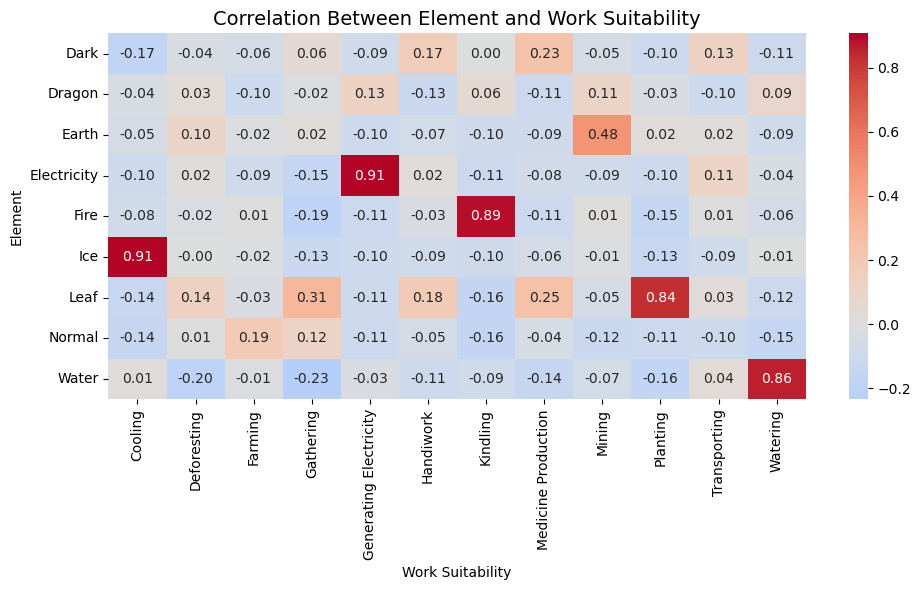

In [9]:
plot_element_work_heatmap(pal_info_df, element_cols, work_cols, 
                          "Correlation Between Element and Work Suitability", 
                          "Work Suitability", "Element")

In [ ]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 

#### visualization 3

In [ ]:
"""
Palworld Weapon Visualizations — Two Plots with Best-Fit Lines
==============================================================

Single-cell utilities to:
1) Normalize a Palworld weapons DataFrame's schema and numeric types.
2) Render two interactive Plotly scatter plots with best-fit lines:
   a) Price vs Physical Attack
   b) Price vs Durability

Best-Fit Method
---------------
- If `log_axes=False`: ordinary least squares (linear fit) in linear space.
- If `log_axes=True`: fit in log–log space (power-law): log(y) = a + b*log(x),
  which corresponds to y = exp(a) * x**b, and display on log axes.

Usage
-----
Assumes a DataFrame `weapons_df` exists in the environment (e.g., from your scraper).
This cell will show both plots inline.
"""


def sanitize_weapons_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize expected column names and coerce numeric types.

    Parameters
    ----------
    df : pandas.DataFrame
        Input frame containing weapon stats, potentially with varied column names.

    Returns
    -------
    pandas.DataFrame
        Copy with normalized columns (if present):
        ['Name', 'Price', 'Physical Attack', 'Durability'].
        Non-numeric entries in numeric fields are coerced to NaN.

    Notes
    -----
    - Common aliases are mapped into canonical names (e.g., 'attack' → 'Physical Attack').
    - If 'Name' is missing, an index-based string name is synthesized.
    """
    data = df.copy()

    rename_map = {
        "name": "Name",
        "item_name": "Name",
        "price": "Price",
        "physical_attack": "Physical Attack",
        "attack": "Physical Attack",
        "phys_atk": "Physical Attack",
        "durability": "Durability",
    }
    lowered = {c.lower(): c for c in data.columns}
    for k, v in rename_map.items():
        if k in lowered and v not in data.columns:
            data.rename(columns={lowered[k]: v}, inplace=True)

    for col in ["Price", "Physical Attack", "Durability"]:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors="coerce")

    data["Name"] = data.get("Name", data.index).astype(str)
    return data


def _best_fit_line(x: np.ndarray, y: np.ndarray, log_axes: bool) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute best-fit line coordinates over the span of x.

    Parameters
    ----------
    x, y : np.ndarray
        1-D arrays of equal length (NaNs removed by caller).
    log_axes : bool
        If True, fit in log–log space (power-law). Otherwise, linear fit.

    Returns
    -------
    x_fit, y_fit : np.ndarray
        Sorted x over its range and corresponding fitted y values.
    """
    # Sort by x for a clean line
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]

    if log_axes:
        # Filter to positive values (log domain)
        mask = (x_sorted > 0) & (y_sorted > 0)
        xz = x_sorted[mask]
        yz = y_sorted[mask]
        if len(xz) < 2:
            return x_sorted, np.full_like(x_sorted, np.nan)

        lx, ly = np.log(xz), np.log(yz)
        b, a = np.polyfit(lx, ly, 1)  # ly ≈ a + b*lx
        y_fit = np.exp(a) * x_sorted**b
        return x_sorted, y_fit
    else:
        if len(x_sorted) < 2:
            return x_sorted, np.full_like(x_sorted, np.nan)
        m, c = np.polyfit(x_sorted, y_sorted, 1)  # y ≈ m*x + c
        y_fit = m * x_sorted + c
        return x_sorted, y_fit


def interactive_scatter_with_fit(
    df: pd.DataFrame,
    *,
    x: str,
    y: str,
    title: str,
    hover_cols: Optional[Iterable[str]] = None,
    log_axes: bool = True,
    template: str = "simple_white",
    marker_size: int = 8,
    marker_opacity: float = 0.85,
):
    """
    Render a Plotly scatter plot with an overlaid best-fit line.

    Parameters
    ----------
    df : pandas.DataFrame
        Source data frame (will be sanitized).
    x : str
        Column name for the x-axis.
    y : str
        Column name for the y-axis.
    title : str
        Figure title.
    hover_cols : Iterable[str], optional
        Additional columns to include in the hover tooltip, if present.
    log_axes : bool, default True
        If True, plot both axes on a logarithmic scale and fit in log–log space.
    template : str, default "simple_white"
        Plotly template for styling.
    marker_size : int, default 8
        Point size.
    marker_opacity : float, default 0.85
        Point opacity in [0, 1].

    Returns
    -------
    plotly.graph_objects.Figure
        Interactive scatter plot with best-fit line.
    """
    data = sanitize_weapons_df(df).dropna(subset=[x, y]).copy()
    hover_cols = [c for c in (hover_cols or []) if c in data.columns]

    fig = px.scatter(
        data,
        x=x,
        y=y,
        hover_data=["Name", *hover_cols] if "Name" in data.columns else hover_cols,
        title=title,
        log_x=log_axes,
        log_y=log_axes,
        template=template,
    )
    fig.update_traces(marker=dict(size=marker_size, opacity=marker_opacity))

    # Best-fit line
    x_vals = data[x].to_numpy(dtype=float)
    y_vals = data[y].to_numpy(dtype=float)
    mask = ~np.isnan(x_vals) & ~np.isnan(y_vals)
    if mask.sum() >= 2:
        x_fit, y_fit = _best_fit_line(x_vals[mask], y_vals[mask], log_axes)
        fig.add_trace(
            go.Scatter(
                x=x_fit,
                y=y_fit,
                mode="lines",
                name="Best fit",
                hoverinfo="skip",
            )
        )

    fig.show()
    return fig


def plot_weapon_relationships(df: pd.DataFrame, *, log_axes: bool = True, template: str = "simple_white"):
    """
    Produce the two interactive weapon relationship plots with best-fit lines:

      1) Price vs Physical Attack
      2) Price vs Durability

    Parameters
    ----------
    df : pandas.DataFrame
        Weapons data (columns auto-normalized internally).
    log_axes : bool, default True
        Apply log scaling to both axes and use power-law best-fit.
    template : str, default "simple_white"
        Plotly template for styling.

    Returns
    -------
    dict[str, plotly.graph_objects.Figure]
        Figures keyed by:
        {"price_vs_attack", "price_vs_durability"}.
    """
    figs = {}
    figs["price_vs_attack"] = interactive_scatter_with_fit(
        df,
        x="Physical Attack",
        y="Price",
        title="Price vs Physical Attack",
        hover_cols=["Durability"],
        log_axes=log_axes,
        template=template,
    )
    figs["price_vs_durability"] = interactive_scatter_with_fit(
        df,
        x="Durability",
        y="Price",
        title="Price vs Durability",
        hover_cols=["Physical Attack"],
        log_axes=log_axes,
        template=template,
    )
    return figs


# ---- Execute (shows both plots) ----
_ = plot_weapon_relationships(weapons_df, log_axes=True)


## Models

### Modeling functions overview
List all the functions you have written for modeling. For each one, write one sentence to describe it. 
- `fit_linear()`
    - fit a linear model to the data and output the r2, slope and intercept

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering. 

In [ ]:
# list all the functions you have for modeling. Make sure write full 
# docstrings for each function
def fit_linear(df, y_feat, x_feat):

    pass

#### Model 1

In [ ]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

#### Model 2

In [ ]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

In [10]:
def find_k(df, x_feat_list):
    
    # scale numerical features
    for feat in x_feat_list:
        df[feat] = df[feat]/df[feat].std()

    x = df.loc[:, x_feat_list].values

    mean_d_dict = dict()

    # get mean-distance for k 2-10
    for n_clusters in range(2, 20):
        kmeans = KMeans(n_clusters = n_clusters)
        kmeans.fit(x)
        y_pred = kmeans.predict(x)

        mean_d = -kmeans.score(x)
        mean_d_dict[n_clusters] = mean_d

    # plot k-value vs. mean distance
    plt.plot(mean_d_dict.keys(), mean_d_dict.values())
    plt.xticks(np.arange(2, 20))

C:\Users\vunathan36\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vunathan36\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vunathan36\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\vunathan36\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a m

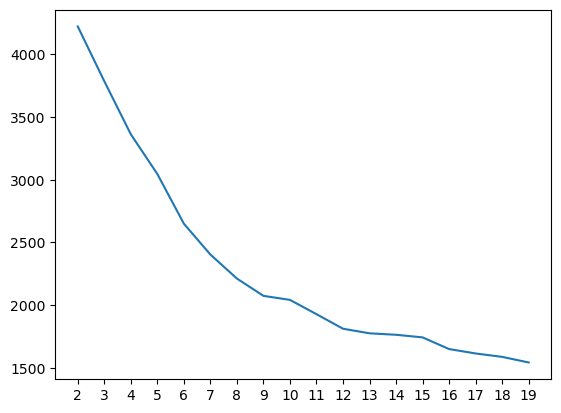

In [11]:
find_k(pal_info_df, all_elements + all_work_types)

The ideal number of clusters appears to be 9.

In [14]:
def kmeans_fit_pred(df, x_feat_list, n_clusters):
    
    x = df.loc[:, x_feat_list].values

    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(x)
    y_pred = kmeans.predict(x)
    
    df['cluster'] = y_pred

In [15]:
kmeans_fit_pred(pal_info_df, all_elements + all_work_types, 9)

C:\Users\vunathan36\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [23]:
cluster_profile = pal_info_df.groupby('cluster')['Rarity Level'].describe()

In [24]:
cluster_profile

,count,unique,top,freq
cluster,,,,
0,31,8,8,8
1,30,9,1,6
2,28,10,7,5
3,28,10,7,6
4,20,8,5,6
5,27,10,3,6
6,18,9,7,4
7,10,7,6,3
8,33,11,3,5


#### Model 3

In [ ]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

# If needed once (uncomment, run, then restart the kernel):
# !pip install plotly ipywidgets pandas numpy

"""
Palworld Weapon Value Dashboard — Head-to-Head - Compare All
"""

# -----------------------
# 0) Load & sanitize data
# -----------------------
def _coalesce_columns(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Harmonize common column name variations to required names.

    Parameters
    ----------
    frame : pandas.DataFrame
        Input DataFrame with potential synonyms for Name, Price,
        Physical Attack, and Durability.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns renamed to: 'Name', 'Price',
        'Physical Attack', 'Durability'.

    Raises
    ------
    ValueError
        If any required column cannot be located by synonym.
    """
    cols = {c.lower().strip(): c for c in frame.columns}

    def pick(*cands: str) -> Optional[str]:
        for c in cands:
            key = c.lower().strip()
            if key in cols:
                return cols[key]
        return None

    rename_map = {}
    name_col = pick("name", "item", "weapon")
    price_col = pick("price", "cost")
    atk_col   = pick("physical attack", "physical_attack", "attack", "atk")
    dur_col   = pick("durability", "dura", "dur")

    if not all([name_col, price_col, atk_col, dur_col]):
        missing = [lbl for lbl, c in
                   [("Name", name_col), ("Price", price_col),
                    ("Physical Attack", atk_col), ("Durability", dur_col)]
                   if c is None]
        raise ValueError(f"Missing required columns: {missing}")

    rename_map[name_col]  = "Name"
    rename_map[price_col] = "Price"
    rename_map[atk_col]   = "Physical Attack"
    rename_map[dur_col]   = "Durability"
    return frame.rename(columns=rename_map)

# Load from in-memory DataFrame if present; else CSV fallback
try:
    df = weapons_df.copy()
    df = _coalesce_columns(df)
except NameError:
    df = pd.read_csv("/mnt/data/palworld_weapons.csv")
    df = _coalesce_columns(df)

# Basic sanitation
for c in ["Price","Physical Attack","Durability"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df["Name"] = df["Name"].astype(str)
df = df.dropna(subset=["Name"]).reset_index(drop=True)

# ----------------------------
# 1) Scoring & variant helpers
# ----------------------------
def compute_value_scores(
    data: pd.DataFrame,
    w_attack: float = 1/3,
    w_durability: float = 1/3,
    w_price_inverse: float = 1/3,
    clamp_0_1: bool = True,
    relative_to_best: bool = False
) -> pd.DataFrame:
    """
    Compute Value %, Attack Score, Durability Score, and Price Efficiency %.

    Method
    ------
    - Min–max normalize each component:
        Attack_norm = (Attack - min) / (max - min)
        Durability_norm = (Durability - min) / (max - min)
        Price_inv = (max(Price) - Price) / (max(Price) - min(Price))
    - Combine with normalized weights:
        Combined = wa*Attack_norm + wd*Durability_norm + wp*Price_inv
    - Optional: re-scale Combined so the top item = 100% among considered rows.

    Parameters
    ----------
    data : pandas.DataFrame
        Data containing columns: 'Price', 'Physical Attack', 'Durability'.
    w_attack : float, default 1/3
        Weight for normalized attack.
    w_durability : float, default 1/3
        Weight for normalized durability.
    w_price_inverse : float, default 1/3
        Weight for normalized inverse-price.
    clamp_0_1 : bool, default True
        Clip combined score into [0, 1] before optional re-scaling.
    relative_to_best : bool, default False
        If True, re-scale the final combined score so the best item is 1.0 (100%).

    Returns
    -------
    pandas.DataFrame
        Original columns plus:
        - 'Value %' (0–100)
        - 'Attack Score' (0–100)
        - 'Durability Score' (0–100)
        - 'Price Efficiency %' (0–100)
    """
    d = data.copy()

    def minmax(x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=float)
        if x.size == 0 or np.all(~np.isfinite(x)):
            return np.zeros_like(x)
        x_min, x_max = np.nanmin(x), np.nanmax(x)
        if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max == x_min:
            return np.zeros_like(x)
        return (x - x_min) / (x_max - x_min)

    a_norm = minmax(d["Physical Attack"].to_numpy())
    d_norm = minmax(d["Durability"].to_numpy())

    p = d["Price"].to_numpy(dtype=float)
    if p.size == 0 or np.all(~np.isfinite(p)) or np.nanmax(p) == np.nanmin(p):
        p_inv = np.zeros_like(p)
    else:
        p_min, p_max = np.nanmin(p), np.nanmax(p)
        p_inv = (p_max - p) / (p_max - p_min)

    w_sum = w_attack + w_durability + w_price_inverse
    wa, wd, wp = ((w_attack, w_durability, w_price_inverse) if w_sum == 0
                  else (w_attack / w_sum, w_durability / w_sum, w_price_inverse / w_sum))

    combined = wa * a_norm + wd * d_norm + wp * p_inv
    if clamp_0_1:
        combined = np.clip(combined, 0.0, 1.0)

    if relative_to_best:
        cmin, cmax = np.nanmin(combined), np.nanmax(combined)
        if np.isfinite(cmin) and np.isfinite(cmax) and cmax > cmin:
            combined = (combined - cmin) / (cmax - cmin)
        else:
            combined = np.zeros_like(combined)

    d["Value %"] = np.round(combined * 100.0, 2)
    d["Attack Score"] = np.round(a_norm * 100.0, 1)
    d["Durability Score"] = np.round(d_norm * 100.0, 1)
    d["Price Efficiency %"] = np.round(p_inv * 100.0, 1)
    return d


def annotate_variant_counts(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Add a count of variants per (Name, Price).

    Parameters
    ----------
    df_raw : pandas.DataFrame
        Scored (or raw) data containing 'Name', 'Price', and at least one metric column.

    Returns
    -------
    pandas.DataFrame
        DataFrame with additional column 'Variants @Price'.
    """
    counts = (
        df_raw.groupby(["Name","Price"], dropna=False)["Physical Attack"]
             .size().rename("Variants @Price").reset_index()
    )
    return df_raw.merge(counts, on=["Name","Price"], how="left")


def pareto_front(group: pd.DataFrame) -> pd.DataFrame:
    """
    Return the Pareto (non-dominated) subset in Attack–Durability space.

    Parameters
    ----------
    group : pandas.DataFrame
        Rows for a single (Name, Price) group.

    Returns
    -------
    pandas.DataFrame
        Subset of non-dominated rows where no other row is >= in both
        Attack and Durability and > in at least one.
    """
    g = group.copy()
    A, D = g["Physical Attack"].to_numpy(), g["Durability"].to_numpy()
    keep = np.ones(len(g), dtype=bool)
    for i in range(len(g)):
        dom = (A >= A[i]) & (D >= D[i]) & ((A > A[i]) | (D > D[i]))
        if np.any(dom):
            keep[i] = False
    return g.loc[keep]


def reduce_variants(scored: pd.DataFrame, how: str = "pareto_or_best") -> pd.DataFrame:
    """
    Aggregate variants within (Name, Price) to a representative row.

    Parameters
    ----------
    scored : pandas.DataFrame
        Scored per-variant data.
    how : {'per_variant','pareto_or_best','best_by_value','median_stats'}, default 'pareto_or_best'
        - 'per_variant'    : keep all variants.
        - 'pareto_or_best' : Pareto front; if >1 remain, keep highest 'Value %'.
        - 'best_by_value'  : keep idxmax('Value %') per (Name, Price).
        - 'median_stats'   : median(Attack, Durability) per (Name, Price); caller re-scores.

    Returns
    -------
    pandas.DataFrame
        Reduced DataFrame according to the chosen strategy.
    """
    if how == "per_variant":
        return scored

    base = scored.dropna(subset=["Name","Price","Physical Attack","Durability"]).copy()

    if how == "best_by_value":
        idx = base.groupby(["Name","Price"])["Value %"].idxmax()
        return base.loc[idx].reset_index(drop=True)

    if how == "median_stats":
        agg = (base.groupby(["Name","Price"], as_index=False)
                    .agg({"Physical Attack":"median","Durability":"median","Price":"first"}))
        return agg  # caller re-scores

    # Default: Pareto → then best-by-value
    reduced = []
    for _, grp in base.groupby(["Name","Price"]):
        pf = pareto_front(grp)
        if len(pf) > 1:
            pf = pf.loc[[pf["Value %"].idxmax()]]
        reduced.append(pf)
    return pd.concat(reduced, ignore_index=True)


def current_scored(wa: float, wd: float, wp: float, variant_mode: str) -> pd.DataFrame:
    """
    Produce the currently-scored, optionally-aggregated dataset.

    Parameters
    ----------
    wa, wd, wp : float
        Effective weights for Attack, Durability, and inverse-Price.
    variant_mode : str
        Aggregation mode passed to `reduce_variants`.

    Returns
    -------
    pandas.DataFrame
        Scored (and optionally aggregated) DataFrame, annotated with 'Variants @Price'.
    """
    rel = bool(value_relative_chk.value)
    per_variant = compute_value_scores(df, wa, wd, wp, relative_to_best=rel)
    per_variant = annotate_variant_counts(per_variant)
    reduced = reduce_variants(per_variant, how=variant_mode)
    if variant_mode == "median_stats":
        reduced = compute_value_scores(reduced, wa, wd, wp, relative_to_best=rel)
        reduced = annotate_variant_counts(reduced)
    return reduced

# --------------------------------
# 2) Ring (donut) meter components
# --------------------------------
PALETTE = {
    "value": "#2563eb",       # blue-600
    "price": "#16a34a",       # green-600
    "attack": "#7c3aed",      # violet-600
    "dur": "#f59e0b",         # amber-500
    "track": "#e5e7eb"        # gray-200
}

def ring_fraction(value_pct: float) -> Tuple[float, float]:
    """
    Split a percentage value into filled vs. remaining slices.

    Parameters
    ----------
    value_pct : float
        Target percentage in [0, 100].

    Returns
    -------
    tuple(float, float)
        (filled, remaining) percentages that sum to 100.
    """
    v = 0.0 if (value_pct is None or (isinstance(value_pct, float) and np.isnan(value_pct))) else float(value_pct)
    v = max(0.0, min(100.0, v))
    return v, 100.0 - v


def _add_ring(fig: go.Figure, row: int, col: int, pct: float, color: str, label: str) -> None:
    """
    Add a single donut trace and store label in trace.name for later annotation.

    Parameters
    ----------
    fig : plotly.graph_objects.Figure
        Figure to which the donut is added.
    row, col : int
        Subplot position.
    pct : float
        Percentage for the filled portion.
    color : str
        Hex color for the filled slice.
    label : str
        Label text to render at the donut center.

    Returns
    -------
    None
    """
    filled, rem = ring_fraction(pct)
    fig.add_trace(
        go.Pie(
            values=[filled, rem],
            hole=0.7,
            sort=False,
            textinfo="none",
            hoverinfo="skip",
            marker=dict(colors=[color, PALETTE["track"]], line=dict(width=0)),
            showlegend=False,
            name=label
        ),
        row=row, col=col
    )


def ring_2x2(value_pct: float, price_eff: float, atk: float, dur: float) -> go.Figure:
    """
    Create a 2×2 grid of donut meters:
      Overall Value | Price Efficiency / Attack | Durability.

    Parameters
    ----------
    value_pct : float
        Overall 'Value %'.
    price_eff : float
        'Price Efficiency %'.
    atk : float
        'Attack Score'.
    dur : float
        'Durability Score'.

    Returns
    -------
    plotly.graph_objects.Figure
        Plotly figure containing the 2×2 donut grid with centered labels.
    """
    specs = [[{"type":"domain"}, {"type":"domain"}],
             [{"type":"domain"}, {"type":"domain"}]]
    fig = make_subplots(rows=2, cols=2, specs=specs, subplot_titles=("","","",""))

    _add_ring(fig, 1, 1, value_pct, PALETTE["value"],  "Value")
    _add_ring(fig, 1, 2, price_eff, PALETTE["price"],  "Price Efficiency")
    _add_ring(fig, 2, 1, atk,       PALETTE["attack"], "Attack")
    _add_ring(fig, 2, 2, dur,       PALETTE["dur"],    "Durability")

    # annotate each donut center using its own domain
    for tr in fig.data:
        if isinstance(tr, go.Pie):
            dom = tr.domain
            x = (dom.x[0] + dom.x[1]) / 2.0
            y = (dom.y[0] + dom.y[1]) / 2.0
            filled = float(tr.values[0])
            fig.add_annotation(
                x=x, y=y, xref="paper", yref="paper",
                text=(f"<span style='font-size:20px; font-weight:700'>{filled:.1f}%</span><br>"
                      f"<span style='font-size:12px; color:#6b7280'>{tr.name}</span>"),
                showarrow=False
            )

    fig.update_layout(template="plotly_white", height=580,
                      margin=dict(l=20, r=20, t=20, b=20))
    return fig


# -------------------------
# 3) UI controls & styling
# -------------------------
display(HTML("""
<style>
:root {
  --card-bg: #ffffff;
  --card-border: #e5e7eb;
  --muted: #6b7280;
  --accent: #2563eb;
}
@media (prefers-color-scheme: dark) {
  :root {
    --card-bg: #0b1220;
    --card-border: #1f2937;
    --muted: #9ca3af;
    --accent: #60a5fa;
  }
}
.jp-RenderedHTMLCommon, .widget-html-content {
  font-family: Inter, -apple-system, Segoe UI, Roboto, Helvetica, Arial, sans-serif;
  font-size: 14px;
}
.widget-label { min-width: 120px; }
.toolbar {
  background: var(--card-bg);
  border: 1px solid var(--card-border);
  border-radius: 12px;
  padding: 8px 10px;
  margin: 4px 0 8px;
  box-shadow: 0 1px 2px rgba(0,0,0,0.04);
}
.h2h-card {
  background: var(--card-bg);
  border: 1px solid var(--card-border);
  border-radius: 14px;
  padding: 12px 14px;
  margin: 4px;
  box-shadow: 0 1px 2px rgba(0,0,0,0.06);
}
.h2h-title { font-weight: 700; margin-bottom: 6px; }
.badge {
  display: inline-block; padding: 2px 8px; border-radius: 999px;
  font-size: 12px; font-weight: 600; background: rgba(37,99,235,0.1); color: var(--accent);
}
.win { color: var(--accent); font-weight: 800; }
.note { color: var(--muted); font-size: 12px; }
hr.soft { border: none; border-top: 1px solid var(--card-border); margin: 8px 0; }
</style>
"""))

# Plotly defaults
px.defaults.template = "plotly_white"
px.defaults.height = 420
px.defaults.width = None

# Presets & manual weights
preset = w.Dropdown(
    description='Preset',
    options=['Balanced (1/3 each)','Budget Buyer (Price⁻¹↑)','Power User (Attack↑)','Tanky (Durability↑)'],
    value='Balanced (1/3 each)'
)
attack_w_in = w.FloatText(description='Attack w', value=1/3, step=0.01)
dur_w_in    = w.FloatText(description='Durab. w', value=1/3, step=0.01)
price_w_in  = w.FloatText(description='Price⁻¹ w', value=1/3, step=0.01)

# Variant aggregation
agg_mode = w.Dropdown(
    description='Variants',
    options=[
        ('Per-variant (none)','per_variant'),
        ('Pareto→Best','pareto_or_best'),
        ('Best by Value','best_by_value'),
        ('Median Stats','median_stats')
    ],
    value='pareto_or_best'
)

# Modes
mode = w.ToggleButtons(options=['Single', 'Head-to-Head', 'Compare All'], value='Single')

# Extra toggle: value% normalization to top
value_relative_chk = w.Checkbox(description='Scale Value% so top = 100', value=True)

# Head-to-Head controls
names_init = sorted(df['Name'].dropna().unique().tolist())
swap_btn = w.Button(description='Swap', tooltip='Swap left/right selections')
left_dd  = w.Dropdown(description='Left',  options=names_init, value=names_init[0] if names_init else None)
right_dd = w.Dropdown(description='Right', options=names_init, value=names_init[1] if len(names_init)>1 else (names_init[0] if names_init else None))

# Single weapon control
weapon_dd = w.Dropdown(description='Weapon', options=names_init, value=names_init[0] if names_init else None)

# Ranking controls (simplified)
rank_metric = w.Dropdown(
    description='Rank by',
    options=['Value %','Price Efficiency %','Attack Score','Durability Score',
             'Price','Physical Attack','Durability'],
    value='Value %'
)
rank_asc = w.Checkbox(description='Ascending', value=False)
rank_topn = w.IntSlider(description='Top-N', min=5, max=max(5, min(100, len(names_init))), step=1,
                        value=min(15, max(5, len(names_init))), continuous_update=False)

# Outputs
out_main = w.Output()
out_rank = w.Output()

# ----------------------
# 4) Ranking API (DF out)
# ----------------------
def get_ranked_df(
    metric: str = "Value %",
    ascending: bool = False,
    topn: int = 15,
    variant_mode: str = "pareto_or_best",
    wa: float = 1/3, wd: float = 1/3, wp: float = 1/3
) -> pd.DataFrame:
    """
    Return a ranked view of the (scored + aggregated) dataset.

    Parameters
    ----------
    metric : str, default 'Value %'
        Column to sort by.
    ascending : bool, default False
        Sort order.
    topn : int, default 15
        Number of rows to return.
    variant_mode : str, default 'pareto_or_best'
        Aggregation mode (passed to `current_scored`).
    wa, wd, wp : float, default 1/3 each
        Weights for Attack, Durability, and inverse-Price.

    Returns
    -------
    pandas.DataFrame
        Top-N ranked DataFrame with key score columns.

    Raises
    ------
    ValueError
        If the requested `metric` is not present in the scored view.
    """
    scored = current_scored(wa, wd, wp, variant_mode)
    cols = ['Name','Price','Physical Attack','Durability',
            'Value %','Price Efficiency %','Attack Score','Durability Score','Variants @Price']
    avail = [c for c in cols if c in scored.columns]
    view = scored[avail].copy()
    if metric not in view.columns:
        raise ValueError(f"Metric '{metric}' not found. Available: {view.columns.tolist()}")
    return (view.sort_values(metric, ascending=ascending)
                .head(int(topn)).reset_index(drop=True))

# -------------------------
# 5) Render & interactions
# -------------------------
def apply_preset(label: str) -> Tuple[float,float,float]:
    """
    Map preset label to raw (Attack, Durability, Price⁻¹) weights.

    Parameters
    ----------
    label : str
        Preset label.

    Returns
    -------
    tuple(float, float, float)
        Raw weights before normalization.
    """
    if label.startswith('Balanced'):     return (1/3,1/3,1/3)
    if label.startswith('Budget Buyer'): return (0.2,0.2,0.6)
    if label.startswith('Power User'):   return (0.6,0.2,0.2)
    if label.startswith('Tanky'):        return (0.2,0.6,0.2)
    return (1/3,1/3,1/3)


def _effective_weights() -> Tuple[float,float,float]:
    """
    Normalize current manual weights to sum to 1.

    Returns
    -------
    tuple(float, float, float)
        (wa, wd, wp) that sum to 1, or (1/3,1/3,1/3) if total <= 0.
    """
    a, d, p = float(attack_w_in.value or 0), float(dur_w_in.value or 0), float(price_w_in.value or 0)
    s = a + d + p
    if s <= 0:
        return (1/3, 1/3, 1/3)
    return (a/s, d/s, p/s)


def _winner_tag(a: float, b: float) -> tuple[str, str]:
    """
    Determine CSS 'winner' class for a pairwise comparison.

    Parameters
    ----------
    a, b : float
        Values to compare.

    Returns
    -------
    tuple(str, str)
        ('win','') if a>b; ('','win') if b>a; otherwise ('','').
    """
    if not np.isfinite(a) or not np.isfinite(b) or a == b:
        return "", ""
    return ("win","") if a > b else ("","win")


def _best_row_for_name(scored: pd.DataFrame, nm: str) -> Optional[pd.Series]:
    """
    Select the best variant row for a given weapon name (highest 'Value %').

    Parameters
    ----------
    scored : pandas.DataFrame
        Scored dataset (possibly aggregated).
    nm : str
        Weapon name to select.

    Returns
    -------
    pandas.Series or None
        The best row for `nm`, or None if not found.
    """
    cand = scored[scored['Name'] == nm]
    if cand.empty:
        return None
    return cand.loc[cand['Value %'].idxmax()]


def _format_price(x) -> str:
    """
    Human-readable price formatter.

    Parameters
    ----------
    x : float or int
        Price value.

    Returns
    -------
    str
        Price with thousands separators, or the raw string if not finite.
    """
    return f"{int(x):,}" if np.isfinite(x) else str(x)


def toolbar(*widgets) -> w.Box:
    """
    Wrap controls in a styled toolbar box with spacing.

    Parameters
    ----------
    *widgets
        Any ipywidgets instances to include in the toolbar.

    Returns
    -------
    ipywidgets.Box
        A Box container with preset spacing and CSS class.
    """
    return w.Box(children=list(widgets),
                 layout=w.Layout(gap="10px"),
                 _dom_classes=["toolbar"])


# Re-entrancy guards to prevent duplicate renders
_RENDERING = False
_RENDERING_RANK = False

def render(_=None) -> None:
    """
    Main dashboard renderer (Single / Head-to-Head / Compare All).

    Notes
    -----
    - Re-entrancy guard prevents duplicate renders when presets programmatically
      update manual weight inputs.
    - Uses the current preset/manual weights and variant aggregation to produce
      donuts (Single), H2H cards/bars (Head-to-Head), or overview plots (Compare All).
    """
    global _RENDERING
    if _RENDERING:
        return
    _RENDERING = True
    try:
        with out_main:
            clear_output(wait=True)

            # Apply preset → set manual inputs (without spamming events)
            pa, pd_, pp = apply_preset(preset.value)
            for widget, val in ((attack_w_in, pa), (dur_w_in, pd_), (price_w_in, pp)):
                try:
                    with widget.hold_trait_notifications():
                        widget.value = float(val)
                except Exception:
                    widget.value = float(val)

            wa, wd, wp = _effective_weights()

            # Score and aggregate per current variant mode
            scored = current_scored(wa, wd, wp, agg_mode.value)

            # Top control bar (manual weights)
            display(toolbar(preset, attack_w_in, dur_w_in, price_w_in, agg_mode, value_relative_chk))
            display(HTML(f"<div class='note'><b>Effective weights</b>: "
                         f"Attack {wa:.2f} · Durability {wd:.2f} · Price⁻¹ {wp:.2f}</div>"))

            # Mode-specific controls
            if mode.value == 'Single':
                # Keep dropdown in sync
                weapon_dd.options = sorted(scored['Name'].dropna().unique().tolist())
                if weapon_dd.value not in weapon_dd.options and weapon_dd.options:
                    weapon_dd.value = weapon_dd.options[0]
                display(toolbar(weapon_dd))

                sel = scored.loc[scored['Name'] == weapon_dd.value]
                if not sel.empty:
                    r = sel.iloc[0]
                    fig = ring_2x2(
                        value_pct = float(r['Value %']),
                        price_eff = float(r['Price Efficiency %']),
                        atk       = float(r['Attack Score']),
                        dur       = float(r['Durability Score'])
                    )
                    display(fig)
                    price_text = _format_price(r["Price"])
                    display(HTML(f"<div class='note'>Price: {price_text} · Variants @Price: "
                                 f"{int(r['Variants @Price']) if np.isfinite(r['Variants @Price']) else r['Variants @Price']}</div>"))
                else:
                    display(HTML("<i>No selection available under current filters.</i>"))

            elif mode.value == 'Head-to-Head':
                names_now = sorted(scored['Name'].dropna().unique().tolist())

                # Sync dropdowns
                left_dd.options = names_now
                right_dd.options = names_now
                if left_dd.value not in names_now and names_now:
                    left_dd.value = names_now[0]
                if right_dd.value not in names_now and len(names_now) > 1:
                    right_dd.value = names_now[1] if left_dd.value == names_now[0] else names_now[0]

                # UI row: left | swap | right
                top_row = toolbar(left_dd, swap_btn, right_dd)
                display(top_row)

                lrow = _best_row_for_name(scored, left_dd.value)
                rrow = _best_row_for_name(scored, right_dd.value)

                if lrow is None or rrow is None:
                    display(HTML("<i>Pick two valid weapons to compare.</i>"))
                else:
                    # Winner highlights
                    lv, rv = float(lrow['Value %']), float(rrow['Value %'])
                    lve, rve = _winner_tag(lv, rv)
                    lpe, rpe = _winner_tag(float(lrow['Price Efficiency %']), float(rrow['Price Efficiency %']))
                    lak, rak = _winner_tag(float(lrow['Attack Score']), float(rrow['Attack Score']))
                    ldu, rdu = _winner_tag(float(lrow['Durability Score']), float(rrow['Durability Score']))

                    # Headline cards
                    html = f"""
                    <div style="display:flex; gap:12px; margin-top:8px;">
                      <div class="h2h-card" style="flex:1;">
                        <div class="h2h-title">{left_dd.value} <span class="badge">{'Winner' if lve=='win' else 'Challenger'}</span></div>
                        <div>Value: <span class="{lve}">{lv:.1f}%</span></div>
                        <div>Price Eff.: <span class="{lpe}">{float(lrow['Price Efficiency %']):.1f}%</span></div>
                        <div>Attack: <span class="{lak}">{float(lrow['Attack Score']):.1f}%</span></div>
                        <div>Durability: <span class="{ldu}">{float(lrow['Durability Score']):.1f}%</span></div>
                        <div class="note" style="margin-top:4px;">Price: {_format_price(lrow['Price'])} · Variants @Price: {int(lrow['Variants @Price']) if np.isfinite(lrow['Variants @Price']) else lrow['Variants @Price']}</div>
                      </div>
                      <div class="h2h-card" style="flex:1;">
                        <div class="h2h-title">{right_dd.value} <span class="badge">{'Winner' if rve=='win' else 'Challenger'}</span></div>
                        <div>Value: <span class="{rve}">{rv:.1f}%</span></div>
                        <div>Price Eff.: <span class="{rpe}">{float(rrow['Price Efficiency %']):.1f}%</span></div>
                        <div>Attack: <span class="{rak}">{float(rrow['Attack Score']):.1f}%</span></div>
                        <div>Durability: <span class="{rdu}">{float(rrow['Durability Score']):.1f}%</span></div>
                        <div class="note" style="margin-top:4px;">Price: {_format_price(rrow['Price'])} · Variants @Price: {int(rrow['Variants @Price']) if np.isfinite(rrow['Variants @Price']) else rrow['Variants @Price']}</div>
                      </div>
                    </div>
                    """
                    display(HTML(html))

                    # Bar comparison on key metrics
                    comp_df = pd.DataFrame({
                        'Metric': ['Value %','Price Efficiency %','Attack Score','Durability Score'],
                        left_dd.value: [lv, float(lrow['Price Efficiency %']), float(lrow['Attack Score']), float(lrow['Durability Score'])],
                        right_dd.value: [rv, float(rrow['Price Efficiency %']), float(rrow['Attack Score']), float(rrow['Durability Score'])]
                    })
                    comp_m = comp_df.melt(id_vars='Metric', var_name='Weapon', value_name='Score')
                    fig_comp = px.bar(
                        comp_m, x='Metric', y='Score', color='Weapon', barmode='group',
                        title='Head-to-Head — Key Metrics'
                    )
                    fig_comp.update_layout(margin=dict(l=10,r=10,t=50,b=10), height=420)
                    fig_comp.update_traces(texttemplate='%{y:.1f}', textposition='outside', cliponaxis=False)
                    display(fig_comp)

            else:  # Compare All (always all items)
                comp = scored.copy()
                if not comp.empty:
                    fig_bar = px.bar(
                        comp.sort_values('Value %', ascending=False),
                        x='Name', y='Value %',
                        hover_data={'Price':':,','Physical Attack':':.0f','Durability':':.0f',
                                    'Variants @Price':':.0f','Price Efficiency %':':.1f',
                                    'Attack Score':':.1f','Durability Score':':.1f'},
                        title='Overall Value % (Current Weights)'
                    )
                    fig_bar.update_traces(texttemplate='%{y:.1f}', textposition='outside', cliponaxis=False)
                    fig_bar.update_layout(margin=dict(l=10,r=10,t=50,b=10), height=420)

                    rad = comp[['Name','Price Efficiency %','Attack Score','Durability Score']].melt(
                        id_vars='Name', var_name='Metric', value_name='Score'
                    )
                    fig_radar = px.line_polar(
                        rad, r='Score', theta='Metric', color='Name', line_close=True,
                        title='Component Scores (Current Weights)'
                    )
                    fig_radar.update_traces(mode='lines+markers')
                    fig_radar.update_layout(
                        polar=dict(radialaxis=dict(range=[0,100], tickfont=dict(size=10))),
                        margin=dict(l=10,r=10,t=50,b=10), height=420
                    )

                    left, right = w.Output(), w.Output()
                    with left: display(fig_bar)
                    with right: display(fig_radar)
                    display(w.HBox([left, right]))
                else:
                    display(HTML("<i>No items to compare.</i>"))
    finally:
        _RENDERING = False


def render_ranking(_=None) -> None:
    """
    Render the interactive ranking controls and table.

    Notes
    -----
    - Ranking reflects the current effective weights and variant aggregation.
    - UI intentionally minimal: Rank-by selector, ascending toggle, and Top-N.
    """
    global _RENDERING_RANK
    if _RENDERING_RANK:
        return
    _RENDERING_RANK = True
    try:
        with out_rank:
            clear_output(wait=True)
            wa, wd, wp = _effective_weights()

            ranked = get_ranked_df(
                metric=rank_metric.value,
                ascending=rank_asc.value,
                topn=rank_topn.value,
                variant_mode=agg_mode.value,
                wa=wa, wd=wd, wp=wp
            )

            display(HTML("<hr class='soft'><h3 style='margin:6px 0;'>Interactive Ranking</h3>"))
            ctrls = toolbar(rank_metric, rank_asc, rank_topn)
            display(ctrls)
            try:
                display(ranked.style.hide(axis='index'))
            except Exception:
                display(ranked)
    finally:
        _RENDERING_RANK = False

# ------------- wiring & launch -------------
def _on_swap(_btn):
    """
    Swap left/right selections for Head-to-Head.

    Parameters
    ----------
    _btn : ipywidgets.Button
        The button instance (unused).
    """
    left_dd.value, right_dd.value = right_dd.value, left_dd.value

swap_btn.on_click(_on_swap)

# Any change here re-renders dashboard
for ctl in (preset, attack_w_in, dur_w_in, price_w_in, agg_mode, mode,
            weapon_dd, left_dd, right_dd, value_relative_chk):
    ctl.observe(render, names='value')

# Ranking reacts to these as well
for ctl in (rank_metric, rank_asc, rank_topn,
            agg_mode, attack_w_in, dur_w_in, price_w_in, value_relative_chk):
    ctl.observe(render_ranking, names='value')

display(mode)
render()
display(out_main)
render_ranking()
display(out_rank)

## Discussion

- One or two paragraphs to summarize your findings in the modeling sections and do the models answer your research question?
- Any other potential thing you can do with the analysis (eg: include more features, get more data, try some other models etc.)
- List the contribution for each group member.